In [1]:
%matplotlib inline

import numpy as np
import datetime
from matplotlib import pyplot as plt
from lipton_tarjan import PlanarGraphGenerator, PlanarSeparator, SeparationClass

np.random.seed(42)

In [2]:
def is_correct_separation(graph, separation):

    if np.any(separation == SeparationClass.UNDEFINED):
        return False
    
    first_part_cost = graph.vertex_costs[separation == int(SeparationClass.FIRST_PART)].sum()
    second_part_cost = graph.vertex_costs[separation == int(SeparationClass.SECOND_PART)].sum()

    if max(first_part_cost, second_part_cost) > 2/3:
        return False

    separator_size = (separation == SeparationClass.SEPARATOR).sum()

    if separator_size > 2*np.sqrt(2)*np.sqrt(graph.size):
        return False

    for vertex, sep_class in enumerate(separation):

        if sep_class == SeparationClass.FIRST_PART or \
                sep_class == SeparationClass.SECOND_PART:

            for adjacent_vertex in graph.get_adjacent_vertices(vertex):
                if separation[adjacent_vertex] != SeparationClass.SEPARATOR and \
                        separation[adjacent_vertex] != sep_class:
                    return False

    return True

In [3]:
def get_experimental_statistics(graph_size_log2s, sample_size, random_vertex_costs):

    all_separations_are_correct = True

    density_values = [0.4, 0.7, 1.0]

    densities = []
    execution_time_seconds = []
    max_part_costs = []
    separator_sizes = []

    for graph_size_log2 in graph_size_log2s:

        graph_size = 2**graph_size_log2

        for sample_index in range(sample_size):

            density = density_values[sample_index%len(density_values)]
            densities.append(density)

            graph = PlanarGraphGenerator.generate_random_graph(graph_size,
                    density, random_vertex_costs=random_vertex_costs)

            start_moment = datetime.datetime.now()
            separation = PlanarSeparator.mark_separation(graph)
            execution_seconds_passed = (datetime.datetime.now() - start_moment).total_seconds()

            execution_time_seconds.append(execution_seconds_passed)

            if not is_correct_separation(graph, separation):
                all_separations_are_correct = False

            first_part_cost = graph.vertex_costs[separation == SeparationClass.FIRST_PART].sum()
            second_part_cost = graph.vertex_costs[separation == SeparationClass.SECOND_PART].sum()
            max_part_cost = max(first_part_cost, second_part_cost)

            separator_size = (separation == SeparationClass.SEPARATOR).sum()

            max_part_costs.append(max_part_cost)
            separator_sizes.append(separator_size)
            
        print('done with size {}'.format(graph_size))

    return all_separations_are_correct, np.array(densities), np.array(execution_time_seconds), \
            np.array(max_part_costs), np.array(separator_sizes)

def draw_plots(graph_size_log2s, sample_size, densities, execution_time_seconds, max_part_costs,
               separator_sizes, random_vertex_costs):

    point_graph_size_log2s = np.repeat(graph_size_log2s, sample_size)

    costs = 'uniform'
    if random_vertex_costs:
        costs = 'random'

    density_values = np.unique(densities)
        
    plt.figure(figsize=(8, 18))

    plt.subplot(3, 1, 1)

    plt.plot(point_graph_size_log2s, point_graph_size_log2s - 7, label='linear tan')
    
    for density in density_values:

        density_mask = (densities == density)
        plt.scatter(point_graph_size_log2s[density_mask],
                np.log(execution_time_seconds[density_mask]), c='r', s=10, alpha=density,
                label='density={:.2f}'.format(density))

    plt.legend()
    plt.title('Runtime(graph size), {} costs'.format(costs))
    plt.xlabel('log2(graph size)')
    plt.ylabel('log(sec.)')

    plt.subplot(3, 1, 2)

    plt.plot(point_graph_size_log2s, [2/3]*len(point_graph_size_log2s), label='Upper bound (2/3)')
    plt.scatter(point_graph_size_log2s, max_part_costs, s=10, c='r', label='experimental points')
    plt.legend()
    plt.title('Max part cost(graph size), {} costs'.format(costs))
    plt.xlabel('log2(graph size)')
    plt.ylabel('Max part cost')

    plt.subplot(3, 1, 3)

    plt.plot(point_graph_size_log2s, 2*np.sqrt(2)*np.sqrt(2**point_graph_size_log2s), label='Upper bound')
    plt.scatter(point_graph_size_log2s, separator_sizes, s=10, c='r', label='experimental points')
    plt.legend()
    plt.title('Separator size(graph size), {} costs'.format(costs))
    plt.xlabel('log2(graph size)')
    plt.ylabel('Separator size')

    plt.savefig('{}.png'.format(costs))

done with size 8
done with size 16
done with size 32
done with size 64
done with size 128
done with size 256
done with size 512
done with size 1024
All separations are correct - True
Total separation time - 3.85 sec.


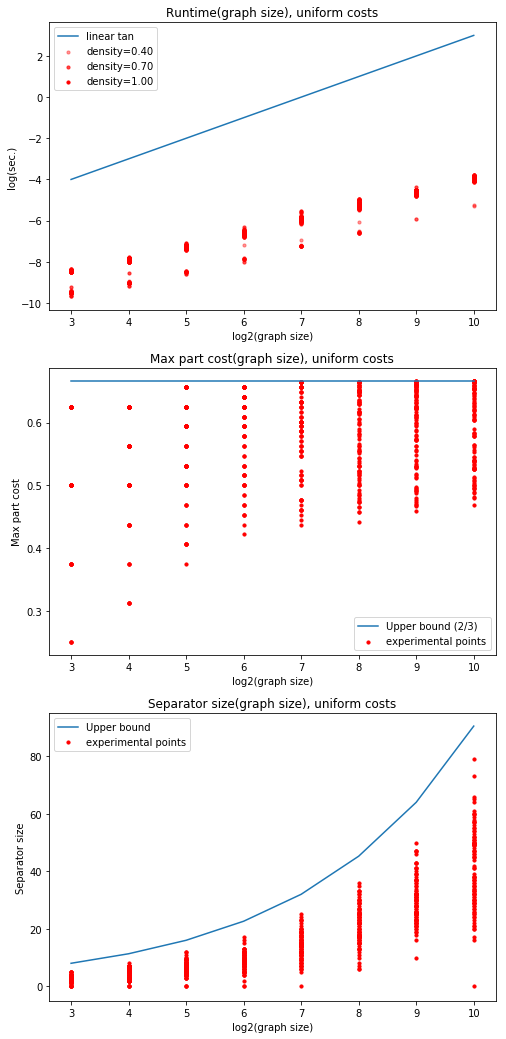

In [4]:
graph_size_log2s = np.arange(3, 11)
sample_size = 100

all_separations_are_correct, densities, execution_time_seconds, max_part_costs, separator_sizes = \
        get_experimental_statistics(graph_size_log2s, sample_size, False)

print('All separations are correct - {}'.format(all_separations_are_correct))
print('Total separation time - {:.2f} sec.'.format(execution_time_seconds.sum()))

draw_plots(graph_size_log2s, sample_size, densities, execution_time_seconds, max_part_costs,
        separator_sizes, False)

In [ ]:
all_separations_are_correct, densities, execution_time_seconds, max_part_costs, separator_sizes = \
        get_experimental_statistics(graph_size_log2s, sample_size, True)

print('All separations are correct - {}'.format(all_separations_are_correct))
print('Total separation time - {:.2f} sec.'.format(execution_time_seconds.sum()))

draw_plots(graph_size_log2s, sample_size, densities, execution_time_seconds, max_part_costs,
        separator_sizes, True)